# Import Libraries and data

In [1]:
# Load libraries
suppressPackageStartupMessages({

library(tidyverse)
library(dplyr)
library(janitor)
library(caret)
library(lubridate)
#library(randomForest)
library(lightgbm)
    
})

In [2]:
# Import data 
train_df <- read.csv("/kaggle/input/playground-series-s4e12/train.csv")
test_df <- read.csv("/kaggle/input/playground-series-s4e12/test.csv")

# Data Exploration and Preprocessing

In [3]:
summary(train_df)

       id               Age           Gender          Annual.Income   
 Min.   :      0   Min.   :18.00   Length:1200000     Min.   :     1  
 1st Qu.: 300000   1st Qu.:30.00   Class :character   1st Qu.:  8001  
 Median : 600000   Median :41.00   Mode  :character   Median : 23911  
 Mean   : 600000   Mean   :41.15                      Mean   : 32745  
 3rd Qu.: 899999   3rd Qu.:53.00                      3rd Qu.: 44634  
 Max.   :1199999   Max.   :64.00                      Max.   :149997  
                   NA's   :18705                      NA's   :44949   
 Marital.Status     Number.of.Dependents Education.Level     Occupation       
 Length:1200000     Min.   :0.00         Length:1200000     Length:1200000    
 Class :character   1st Qu.:1.00         Class :character   Class :character  
 Mode  :character   Median :2.00         Mode  :character   Mode  :character  
                    Mean   :2.01                                              
                    3rd Qu.:3.00     

In [4]:
# Converts names to snake_case
train_df <- clean_names(train_df)  

In [5]:
# Print the first few rows 
head(train_df)

# Check for missing values
colSums(is.na(train_df))

,id,age,gender,annual_income,marital_status,number_of_dependents,education_level,occupation,health_score,location,⋯,previous_claims,vehicle_age,credit_score,insurance_duration,policy_start_date,customer_feedback,smoking_status,exercise_frequency,property_type,premium_amount
,<int>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,0,19,Female,10049,Married,1,Bachelor's,Self-Employed,22.59876,Urban,⋯,2,17,372,5,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869
2,1,39,Female,31678,Divorced,3,Master's,,15.56973,Rural,⋯,1,12,694,2,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483
3,2,23,Male,25602,Divorced,3,High School,Self-Employed,47.17755,Suburban,⋯,1,14,NA,3,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567
4,3,21,Male,141855,Married,2,Bachelor's,,10.93814,Rural,⋯,1,0,367,1,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765
5,4,21,Male,39651,Single,1,Bachelor's,Self-Employed,20.37609,Rural,⋯,0,8,598,4,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,2022
6,5,29,Male,45963,Married,1,Bachelor's,,33.05320,Urban,⋯,2,4,614,5,2022-05-20 15:21:39.207847,Average,No,Weekly,House,3202


id                  age               gender 
                   0                18705                    0 
       annual_income       marital_status number_of_dependents 
               44949                    0               109672 
     education_level           occupation         health_score 
                   0                    0                74076 
            location          policy_type      previous_claims 
                   0                    0               364029 
         vehicle_age         credit_score   insurance_duration 
                   6               137882                    1 
   policy_start_date    customer_feedback       smoking_status 
                   0                    0                    0 
  exercise_frequency        property_type       premium_amount 
                   0                    0                    0

## Impute NA values

In [6]:
# Replace NA values and drop rows that cannot be imputed
train_df <- train_df %>%
  mutate(
    age = ifelse(is.na(age), median(age, na.rm = TRUE), age),
    annual_income = ifelse(is.na(annual_income), median(annual_income, na.rm = TRUE), annual_income),
    number_of_dependents = ifelse(is.na(number_of_dependents), 
                                  as.numeric(names(sort(table(number_of_dependents), decreasing = TRUE)[1])), 
                                  number_of_dependents),
    health_score = ifelse(is.na(health_score), median(health_score, na.rm = TRUE), health_score),
    previous_claims = ifelse(is.na(previous_claims), 0, previous_claims),
    vehicle_age = ifelse(is.na(vehicle_age), median(vehicle_age, na.rm = TRUE), vehicle_age),
    credit_score = ifelse(is.na(credit_score), mean(credit_score, na.rm = TRUE), credit_score)
  ) %>%
  drop_na()  # Drops rows with remaining NA values

# Check for missing values
colSums(is.na(train_df))

id                  age               gender 
                   0                    0                    0 
       annual_income       marital_status number_of_dependents 
                   0                    0                    0 
     education_level           occupation         health_score 
                   0                    0                    0 
            location          policy_type      previous_claims 
                   0                    0                    0 
         vehicle_age         credit_score   insurance_duration 
                   0                    0                    0 
   policy_start_date    customer_feedback       smoking_status 
                   0                    0                    0 
  exercise_frequency        property_type       premium_amount 
                   0                    0                    0

## Convert dates and categorical values

In [7]:
train_df <- train_df %>%
  mutate(across(c(gender, marital_status, education_level, occupation, 
                  location, policy_type, customer_feedback, smoking_status, 
                  property_type), as.factor),
         policy_start_date = as.Date(policy_start_date),
         across(c(insurance_duration, vehicle_age), as.numeric))

In [8]:
summary(train_df)

       id               age           gender       annual_income   
 Min.   :      0   Min.   :18.00   Female:597429   Min.   :     1  
 1st Qu.: 300000   1st Qu.:30.00   Male  :602570   1st Qu.:  8646  
 Median : 599999   Median :41.00                   Median : 23911  
 Mean   : 599999   Mean   :41.14                   Mean   : 32414  
 3rd Qu.: 900000   3rd Qu.:53.00                   3rd Qu.: 43936  
 Max.   :1199999   Max.   :64.00                   Max.   :149997  
  marital_status   number_of_dependents    education_level  
         : 18529   Min.   :0.0          Bachelor's :303234  
 Divorced:391764   1st Qu.:1.0          High School:289441  
 Married :394315   Median :2.0          Master's   :303817  
 Single  :395391   Mean   :2.1          PhD        :303507  
                   3rd Qu.:3.0                              
                   Max.   :4.0                              
         occupation      health_score        location     
              :358075   Min.   : 2.012

In [9]:
# Clean and check memory usage
gc()

# Check dimensions of the dataset
dim(train_df)

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,2758996,147.4,7775897,415.3,4893695,261.4
Vcells,41942795,320.0,92782574,707.9,92705067,707.3


[1] 1199999      21

# Modeling

In [10]:
# Splitting the data
set.seed(123)
train_index <- createDataPartition(train_df$premium_amount, p = 0.8, list = FALSE)
train_set <- train_df[train_index, ]
test_set <- train_df[-train_index, ]

In [11]:
# Prepare data
train_matrix <- as.matrix(train_set %>% select(-premium_amount))
train_label <- train_set$premium_amount
test_matrix <- as.matrix(test_set %>% select(-premium_amount))

# Create LightGBM dataset
lgb_train <- lgb.Dataset(data = train_matrix, label = train_label)

# Train the model
lgb_model <- lgb.train(
  params = list(objective = "regression", metric = "rmse", boosting_type = "gbdt"),
  data = lgb_train,
  nrounds = 100,
  learning_rate = 0.1,
  num_leaves = 31
)

# Predict and evaluate
pred_lgb <- predict(lgb_model, test_matrix)
lgb_rmse <- sqrt(mean((pred_lgb - test_set$premium_amount)^2))
print(paste("LightGBM RMSE:", lgb_rmse))

Warning message in storage.mode(data) <- "double":
“NAs introduced by coercion”


[1] "LightGBM RMSE: 869.449679999836"


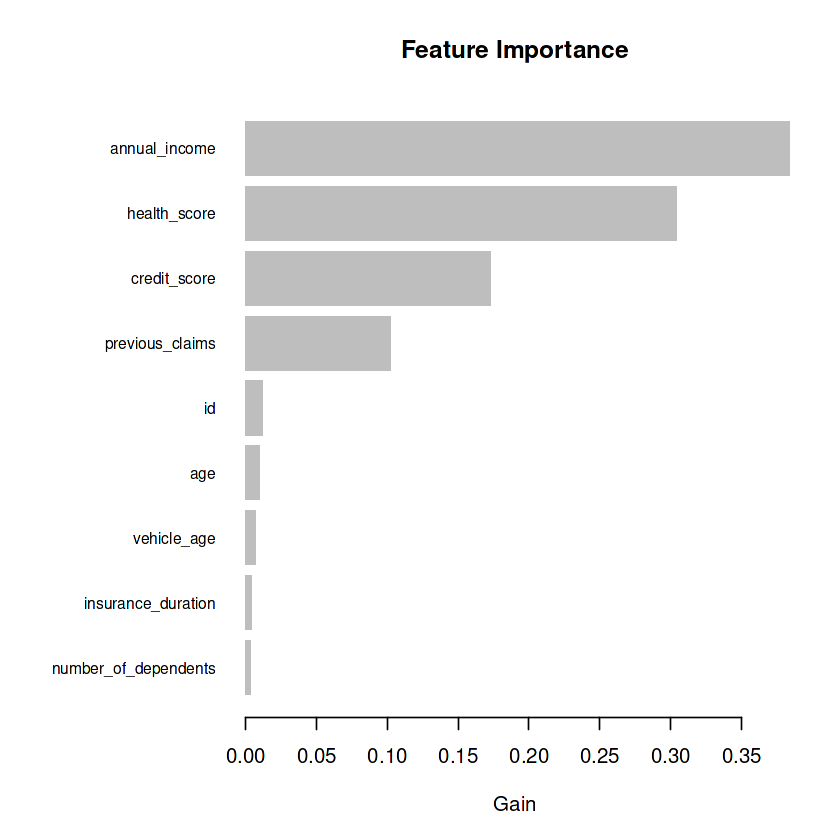

In [12]:
lgb.importance(lgb_model) %>%
  lgb.plot.importance()